In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

from scipy.interpolate import interp1d

In [8]:
RANDOM_SEED = 47
SAMPLE_SIZE = 30_000_000

In [13]:
PERIODS_5 = [[(0, 6)], [(6, 9)], [(9, 15)], [(15, 19)], [(19, 24)]]
PERIODS_4 = [[(6, 9)], [(9, 15)], [(15, 19)], [(0, 6), (19, 24)]]

In [93]:
hours = np.arange(0,25,1)
share_hours = np.array([0.0010, 0.0010, 0.0010, 0.0020, 0.0050, 0.0150, 0.0501, 0.1022, 0.0581, 0.0411, 0.0481, 0.0571, 0.0571,
               0.0521, 0.0651, 0.0982, 0.0852, 0.0832, 0.0651, 0.0451, 0.0301, 0.0220, 0.0100, 0.0050, 0])

In [5]:
INPUT_DIURNAL_FILE = r'C:\Projects\SWIFT\SWIFT_Workspace\CommonData\STM\STM_A\Shared_Inputs\Diurnal_Full_v3.csv'
df_input_diurnal = pd.read_csv(INPUT_DIURNAL_FILE)
seconds, share_seconds = df_input_diurnal.HOUR, df_input_diurnal.SHARE

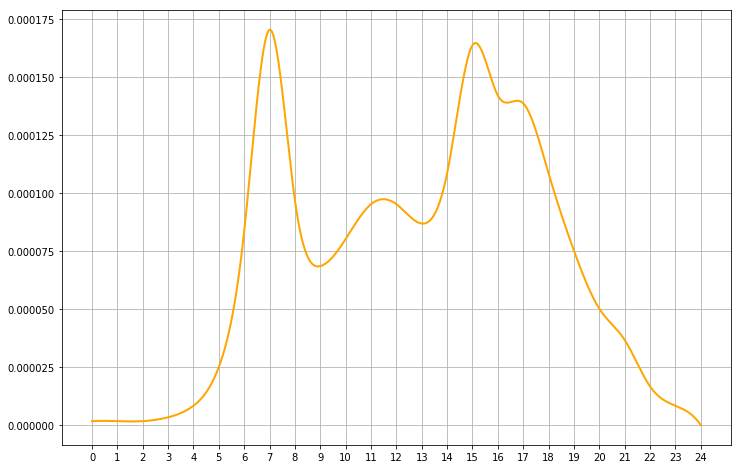

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(seconds, share_seconds, color='orange', linewidth=2, label='Interpolated')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

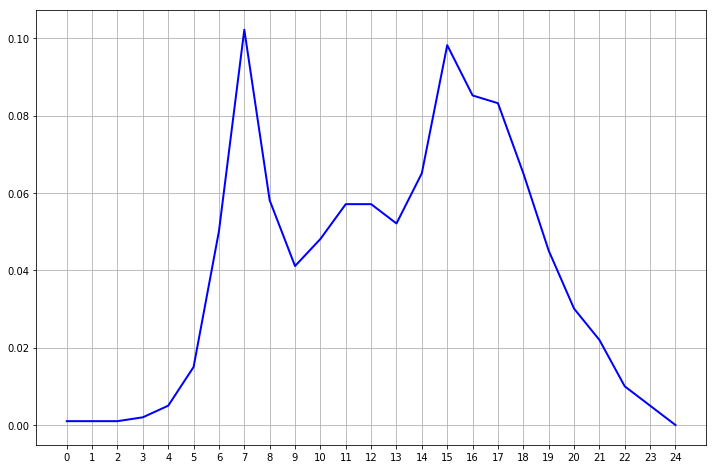

In [94]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hours, share_hours, color='blue', linewidth=2, label='Input')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

In [16]:
def get_period_totals(xs, ys, periods):
    """
    Get period totals
    xs: numpy array
    ys: numpy array
    periods: a list of list containing tuples for periods starting and ending times between 0 and 24.0
    """
    
    totals = {tuple(p): 0 for p in periods}
    for period in periods:
        selector = np.array([False]*len(xs))
        for p in period:
            selector = selector | ((xs >= p[0]) & (xs < p[1]))
        total = np.sum(ys[selector])
        totals[tuple(period)] = total
    return totals

In [24]:
totals_periods_5 = get_period_totals(hours, share_hours, PERIODS_5)
totals_periods_5 = np.array(list(totals_periods_5.values()))
totals_periods_5

array([0.025 , 0.2104, 0.3206, 0.3317, 0.1122])

In [25]:
totals_periods_4 = get_period_totals(hours, share_hours, PERIODS_4)
totals_periods_4 = np.array(list(totals_periods_4.values()))
totals_periods_4

array([0.2104, 0.3206, 0.3317, 0.1372])

In [27]:
totals_periods_5_case1 = np.array([0.056962, 0.138051, 0.35587, 0.327969, 0.121148])
totals_periods_5_case1

array([0.056962, 0.138051, 0.35587 , 0.327969, 0.121148])

1. Calculate period totals
2. Within period totals, compute hourly distribution

In [68]:
def calculate_hourly_probs(xs, ys, period, normalize=False):
    """
    
    period = [0, 6)
    return h: np.array, hours
    pr: np.array probabilities that do NOT sum to 1. need to rescale
    
    """
    
    hr = list(range(period[0], period[1]))
    pr = [0.0 for _ in hr]
    for i, h in enumerate(hr):
        pr[i] += np.sum(ys[np.where((xs>=h) & (xs<h+1))[0]])
    if normalize:
        return np.array(hr), np.array(pr) / sum(pr)
    else:
        return np.array(hr), np.array(pr) 

In [102]:
h, pr = calculate_hourly_probs(seconds, share_seconds, (6, 9))
pr

array([0.08089949, 0.08429533, 0.04555649])

### Case 1 ~ Arbitrary 5 period totals

In [112]:
totals_periods_5_case1

array([0.056962, 0.138051, 0.35587 , 0.327969, 0.121148])

In [75]:
trips = [int(SAMPLE_SIZE*p) for p in totals_periods_5_case1]
trips

[1708860, 4141530, 10676100, 9839070, 3634440]

In [106]:
hourly_trips = []
for trip, period in zip(trips, PERIODS_5):
    h, pr = calculate_hourly_probs(hours, share_hours, period[0], normalize=True)
    t = [trip*p for p in pr]
    hourly_trips.extend(t)

In [107]:
hourly_trips = [t/sum(hourly_trips) for t in hourly_trips]
# hourly_trips = [trip*p for p in pr]

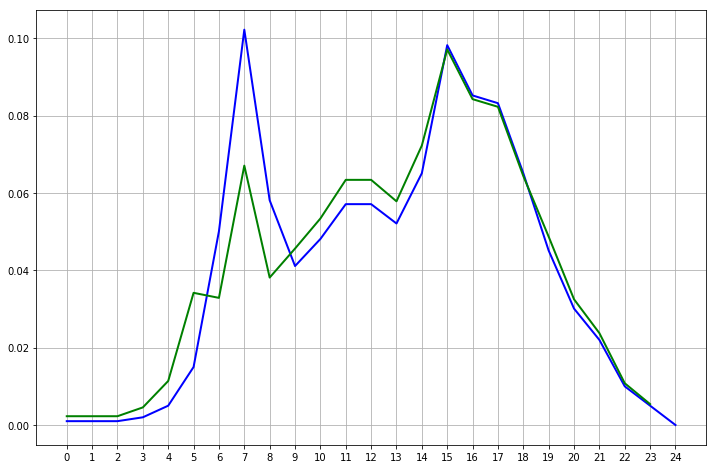

In [108]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hours, share_hours, color='blue', linewidth=2, label='Input')
ax.plot(hours[:-1], hourly_trips, color='green', linewidth=2, label='Output')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

### Case-2 Metropia

In [134]:
# totals_periods_5_case2 = np.array([0.056962, 0.138051, 0.35587 , 0.327969, 0.121148])
totals_periods_5_case2 = np.array([0.025 , 0.2104, 0.3206, 0.3317, 0.1122])
# totals_periods_5_case2 = np.array([0.03420431, 0.16719634, 0.34769134, 0.31725343, 0.13365458])
trips = [int(SAMPLE_SIZE*p) for p in totals_periods_5_case2]
trips

[750000, 6312000, 9618000, 9951000, 3366000]

In [135]:
hourly_trips = []
for trip, period in zip(trips, PERIODS_5):
    h, pr = calculate_hourly_probs(hours, share_hours, period[0], normalize=True)
    t = [trip*p for p in pr]
    hourly_trips.extend(t)
hourly_trips = [t/sum(hourly_trips) for t in hourly_trips]

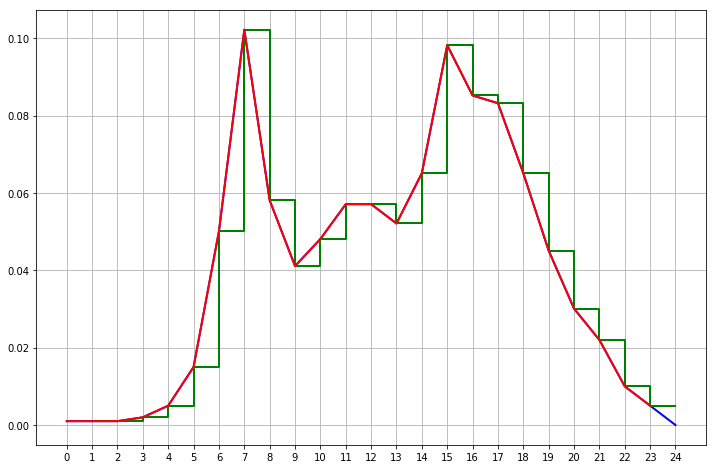

In [136]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hours, share_hours, color='blue', linewidth=2, label='Input')
ax.step(hours[1:], hourly_trips, color='green', linewidth=2, label='Output-Step')
ax.plot(hours[:-1], hourly_trips, color='red', linewidth=2, label='Output-Line')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

## Interpolation

In [160]:
def interpolate(period, xs, ys, time_resolution=6):
    """
    Return ynew based on period length, input xs and ys
    period: period length in hours
    time_resolution: the lowest departure time resolution in seconds. Should be 6 seconds
    """
    
    # get the interpolation points
    step = time_resolution / 3600.0
    xnew = np.clip(np.arange(xs[0], xs[-1]+step, step), a_min=xs[0], a_max=xs[-1])
    f = interp1d(xs, ys, kind='cubic')
    ynew = f(xnew)
    ynew[0], ynew[-1] = ys[0], ys[-1]
    return xnew, ynew

### Whole curve interpolation

In [161]:
x_whole, y_whole = interpolate(24, hours, share)

In [258]:
df_temp = pd.DataFrame({'HOUR': x_whole, 'SHARE': y_whole})
df_temp.to_csv('Diurnal_Full.csv', index=False)

### Period-wise curve interpolation

In [162]:
periods = ((0, 6), (6, 9), (9, 15), (15, 19), (19, 24))
# periods = ((6, 9),)
x_period, y_period = [], []
for period in periods:
    end, start = period[1], period[0]
    xs, ys = hours[np.where((hours>=start) & (hours<=end))], share[np.where((hours>=start) & (hours<=end))]
    x, y = interpolate(end-start, xs, ys)
    x_period, y_period = np.append(x_period, x), np.append(y_period, y)

In [163]:
x_period.shape, y_period.shape

((14405,), (14405,))

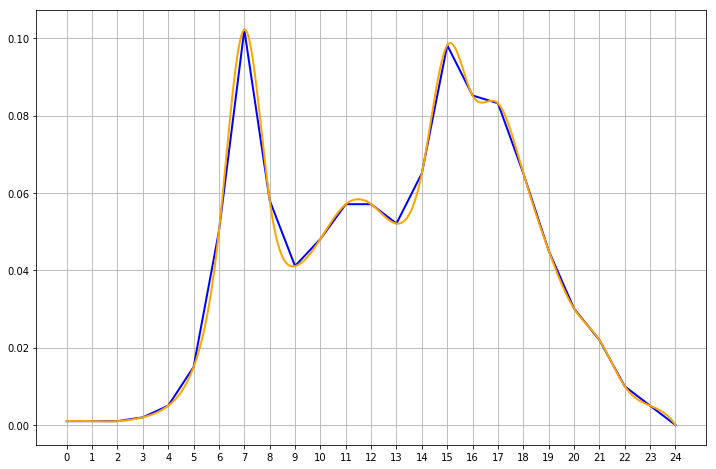

In [166]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hours, share, color='blue', linewidth=2, label='Input')
ax.plot(x_whole, y_whole, color='orange', linewidth=2, label='Wholeday')
# ax.plot(x_period, y_period, color='green', linewidth=2, label='Periodwise')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

In [168]:
df_temp = pd.DataFrame({'hour': x_whole, 'share': y_whole})
df_temp.loc[(df_temp.hour >= 18.99) & (df_temp.hour < 19.002)]

,hour,share
11394,18.990000,0.045281
11395,18.991667,0.045251
11396,18.993333,0.045221
11397,18.995000,0.045190
11398,18.996667,0.045160
11399,18.998333,0.045130
11400,19.000000,0.045100
11401,19.001667,0.045070


In [169]:
df_temp = pd.DataFrame({'hour': x_period, 'share': y_period})
df_temp.loc[(df_temp.hour >= 18.99) & (df_temp.hour < 19.002)]

,hour,share
11397,18.990000,0.045229
11398,18.991667,0.045207
11399,18.993333,0.045186
11400,18.995000,0.045164
11401,18.996667,0.045143
11402,18.998333,0.045121
11403,19.000000,0.045100
11404,19.000000,0.045100
11405,19.001667,0.045059


In [6]:
# INPUT_DIURNAL_FILE = r'C:\Projects\SWIFT\SWIFT_Workspace\CommonData\STM\STM_A\Shared_Inputs\Diurnal_Full.csv'
# INPUT_DIURNAL_FILE = r'L:\DCS\Projects\_Legacy\60563434_SWIFT\400_Technical\SWIFT_Workspace\CommonData\STM\STM_A\Shared_Inputs\Diurnal_Full.csv'
df_input_diurnal = pd.read_csv(INPUT_DIURNAL_FILE)
df_input_diurnal

,HOUR,SHARE
0,0.0,0.000099
1,0.1,0.000103
2,0.2,0.000105
3,0.3,0.000106
4,0.4,0.000107
5,0.5,0.000107
6,0.6,0.000106
7,0.7,0.000105
8,0.8,0.000103
9,0.9,0.000101


In [183]:
xs, ys = df_input_diurnal.HOUR.values, df_input_diurnal.SHARE.values

In [74]:
input_diurnal_em_total = np.sum(ys[np.where((xs>=0) & (xs<6))])
input_diurnal_am_total = np.sum(ys[np.where((xs>=6) & (xs<9))])
input_diurnal_md_total = np.sum(ys[np.where((xs>=9) & (xs<15))])
input_diurnal_pm_total = np.sum(ys[np.where((xs>=15) & (xs<19))])
input_diurnal_ov_total = np.sum(ys[np.where((xs>=19) & (xs<24))])
input_diurnal_period_totals = [input_diurnal_em_total, input_diurnal_am_total, input_diurnal_md_total, input_diurnal_pm_total, input_diurnal_ov_total]
input_diurnal_period_totals

[0.04307980000000001, 0.21027810000000002, 0.3440498, 0.3109679, 0.0916238]

In [75]:
omx_period_totals = [0.056962, 0.138051, 0.355870, 0.327969 ,0.121148]
omx_period_totals

[0.056962, 0.138051, 0.35587, 0.327969, 0.121148]

In [232]:
np.where((xs>=0) & (xs<6))[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

### Conversion with hourly curves and hourly total
This approach was used by Metropia

In [39]:
HOURLY_CURVE_DIURNAL_FILE = r'C:\Projects\SWIFT_Project_Data\Outputs\HGAC_45_fr_diurnal_agg.csv'
df_hourly_curve_diurnal = pd.read_csv(HOURLY_CURVE_DIURNAL_FILE)
df_hourly_curve_diurnal.head()

,Start,Trips
0,0.0,6133
1,0.1,6175
2,0.2,6234
3,0.3,6023
4,0.4,6294


In [228]:
# Period totals by conversion using hourly totals
hourly_curve_diurnal_em_total = np.sum(df_hourly_curve_diurnal.Trips.values[np.where((df_hourly_curve_diurnal.Start>=0) & (df_hourly_curve_diurnal.Start<6))])
hourly_curve_diurnal_am_total = np.sum(df_hourly_curve_diurnal.Trips.values[np.where((df_hourly_curve_diurnal.Start>=6) & (df_hourly_curve_diurnal.Start<9))])
hourly_curve_diurnal_md_total = np.sum(df_hourly_curve_diurnal.Trips.values[np.where((df_hourly_curve_diurnal.Start>=9) & (df_hourly_curve_diurnal.Start<15))])
hourly_curve_diurnal_pm_total = np.sum(df_hourly_curve_diurnal.Trips.values[np.where((df_hourly_curve_diurnal.Start>=15) & (df_hourly_curve_diurnal.Start<19))])
hourly_curve_diurnal_ov_total = np.sum(df_hourly_curve_diurnal.Trips.values[np.where((df_hourly_curve_diurnal.Start>=19) & (df_hourly_curve_diurnal.Start<24))])
hourly_curve_diurnal_period_totals = [hourly_curve_diurnal_em_total, hourly_curve_diurnal_am_total, hourly_curve_diurnal_md_total, 
                                      hourly_curve_diurnal_pm_total, hourly_curve_diurnal_ov_total]
hourly_curve_diurnal_period_totals = hourly_curve_diurnal_period_totals / sum(hourly_curve_diurnal_period_totals)
hourly_curve_diurnal_period_totals

array([0.03420431, 0.16719634, 0.34769134, 0.31725343, 0.13365458])

### DT Generator Class

In [78]:
class DTGenerator:
    def __init__(self, x, prob, seed=0, interp=0, logger=None):
        """

        :param x:      x values for the probability density
        :param prob:   probabilities
        :param seed:   random seed
        :param interp: number of interpolation points
        :param logger: number of interpolation points
        """
        self._prob = prob
        self._x = x
        self._seed = seed
        self._interp = interp

        if len(x) != len(prob):
            if logger is not None:
                logger.error("The lengths of input distribution do not match")
            raise ValueError("The lengths of input distribution do not match")

        self._x_interp = self._x
        self._prob_interp = self._prob
        if interp:
            self._x_interp = np.linspace(x[0], x[-1], self._interp)
            interpolator = interp1d(self._x, self._prob, kind='cubic')
            self._prob_interp = interpolator(self._x_interp)
            self._prob_interp = self._prob_interp / sum(self._prob_interp)
        np.random.seed(self._seed)

    def _select_range(self, period=None):
        """

        :param period: period start and end times
        :type  list of tuples
        :return:
        """
        if period:
            selector = np.array([False]*len(self._x_interp))
            for p in period:
                selector = selector | ((self._x_interp >= p[0]) & (self._x_interp < p[1]))

            xs = self._x_interp[selector]
            probs = self._prob_interp[selector]
            probs = probs / np.sum(probs)
            return probs, xs
        return self._prob_interp, self._x_interp

    def dt(self, period, size=1):
        probs, xs = self._select_range(period)
        return np.random.choice(xs, p=probs, size=size)

In [79]:
dt_gen = DTGenerator(x=xs, prob=ys, interp=0, seed=RANDOM_SEED)

### Simulated with Input Diurnal Period Totals

In [90]:
trips = [int(SAMPLE_SIZE*s) for s in input_diurnal_period_totals]
periods = [[(0,6)], [(6,9)], [(9,15)], [(15,19)], [(19,24)]]

In [91]:
start = time.clock()
departure_times = np.array([])
for trip, period in zip(trips, periods):
    departure_times = np.concatenate([departure_times,dt_gen.dt(period, trip)])
end = time.clock()
print("Total Processing Time = {0:.2f} seconds".format(end-start))

Total Processing Time = 2.56 seconds


In [92]:
hist, bin_edges = np.histogram(departure_times, bins=dt_gen._x_interp, density=False)
hist = hist / sum(hist)

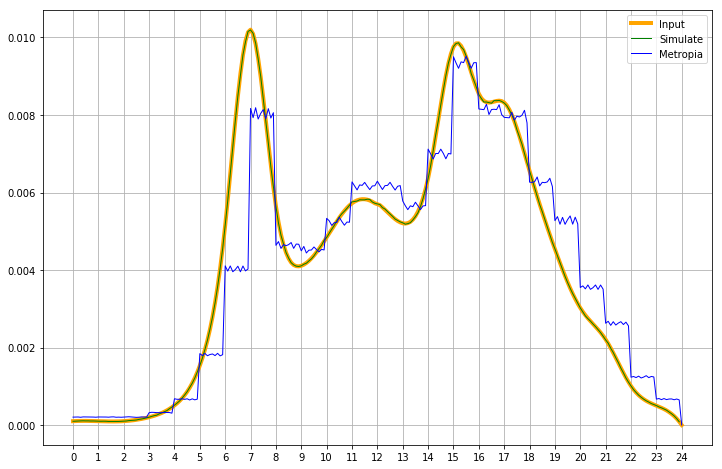

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, ys, color='orange', linewidth=4, label='Input')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=1, label='Simulate')
ax.plot(df_hourly_curve_diurnal.Start, df_hourly_curve_diurnal.Trips / np.sum(df_hourly_curve_diurnal.Trips.values)
       , color='blue', linewidth=1, label='Metropia')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Simulation with Arbitrary Period Totals

In [94]:
trips = [int(SAMPLE_SIZE*s) for s in omx_period_totals]
periods = [[(0,6)], [(6,9)], [(9,15)], [(15,19)], [(19,24)]]

In [95]:
start = time.clock()
departure_times = np.array([])
for trip, period in zip(trips, periods):
    departure_times = np.concatenate([departure_times,dt_gen.dt(period, trip)])
end = time.clock()
print("Total Processing Time = {0:.2f} seconds".format(end-start))

Total Processing Time = 2.48 seconds


In [96]:
hist, bin_edges = np.histogram(departure_times, bins=dt_gen._x_interp, density=False)
hist = hist / sum(hist)

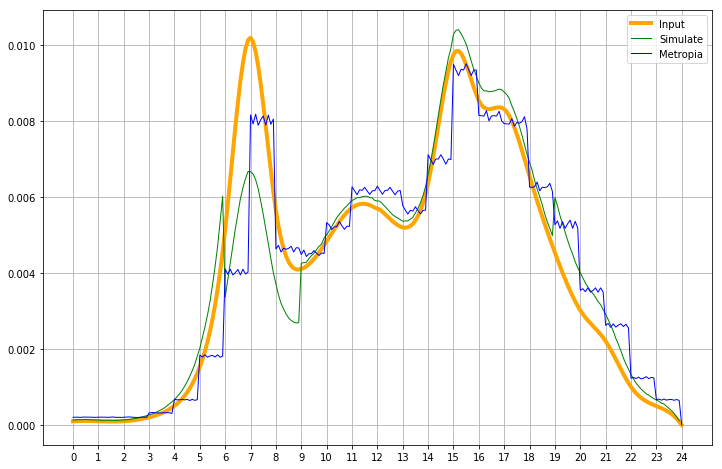

In [97]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, ys, color='orange', linewidth=4, label='Input')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=1, label='Simulate')
ax.plot(df_hourly_curve_diurnal.Start, df_hourly_curve_diurnal.Trips / np.sum(df_hourly_curve_diurnal.Trips.values)
       , color='blue', linewidth=1, label='Metropia')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Simulation with Metropia Period Totals

In [244]:
trips = [int(SAMPLE_SIZE*s) for s in hourly_curve_diurnal_period_totals]
periods = [[(0,6)], [(6,9)], [(9,15)], [(15,19)], [(19,24)]]
start = time.clock()
departure_times = np.array([])
for trip, period in zip(trips, periods):
    departure_times = np.concatenate([departure_times,dt_gen.dt(period, trip)])
end = time.clock()
print("Total Processing Time = {0:.2f} seconds".format(end-start))
hist, bin_edges = np.histogram(departure_times, bins=dt_gen._x_interp, density=False)
hist = hist / sum(hist)

Total Processing Time = 2.46 seconds


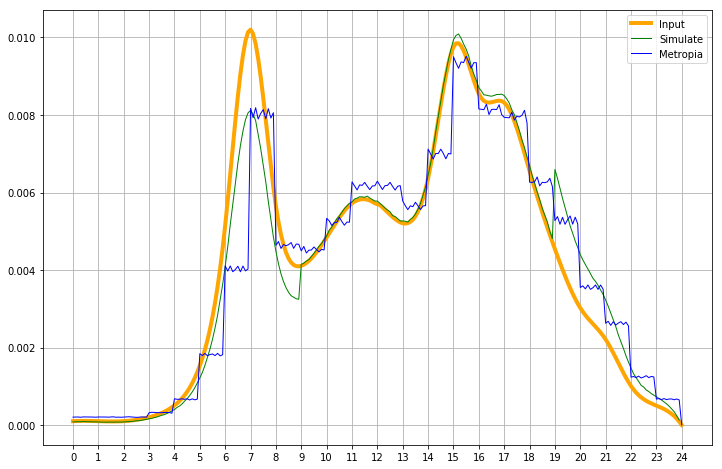

In [245]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, ys, color='orange', linewidth=4, label='Input')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=1, label='Simulate')
ax.plot(df_hourly_curve_diurnal.Start, df_hourly_curve_diurnal.Trips / np.sum(df_hourly_curve_diurnal.Trips.values)
       , color='blue', linewidth=1, label='Metropia')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Drawing with Rescale

In [250]:
def rescale(xs, ys, periods, factors):
    """
    xs, ys: temporal distribution
    periods: [(0,6), (6,9), (9,15), (15,19), (19,24)]
    factors: a list of the same size as periods
    
    return scaled version of temporal distribution
    
    """
    
    ys_scaled = ys.copy()
    for period, factor in zip(periods, factors):
        end, start = period[1], period[0]
        selector = np.where((xs >= start) & (xs < end))
        ys_scaled[selector[0]] = ys_scaled[selector[0]] * factor
    return xs, ys_scaled

In [251]:
factors = [i/h for i, h in zip(input_diurnal_period_totals, hourly_curve_diurnal_period_totals)]
periods = [(0,6), (6,9), (9,15), (15,19), (19,24)]
x_scale, y_scale = rescale(xs=bin_edges[:-1],
                           ys=hist,
                        periods=periods, factors=factors)

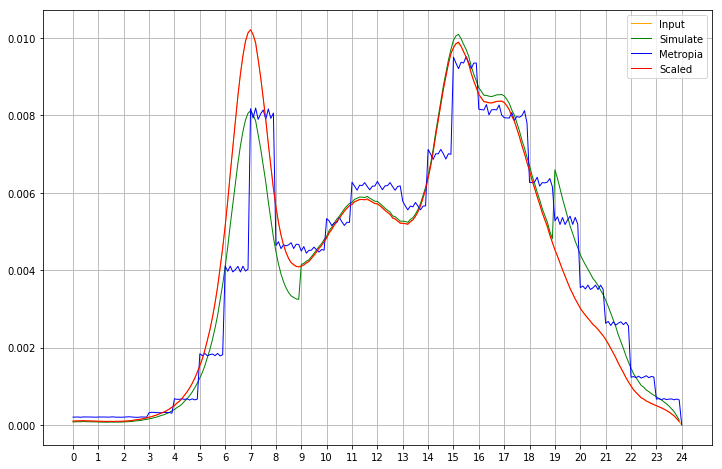

In [256]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, ys, color='orange', linewidth=1, label='Input')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=1, label='Simulate')
ax.plot(df_hourly_curve_diurnal.Start, df_hourly_curve_diurnal.Trips / np.sum(df_hourly_curve_diurnal.Trips.values)
       , color='blue', linewidth=1, label='Metropia')
ax.plot(x_scale, y_scale, color='red', linewidth=1, label='Scaled')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Scratch

In [102]:
df_sim_metropia = pd.DataFrame({'hour': bin_edges[:-1], 'share': hist})

In [103]:
df_sim_metropia.loc[(df_sim_metropia.hour >= 19) & (df_sim_metropia.hour <24), 'share'].sum()

0.1336545755769717